# Artificial Neural Networks and Deep Learning 2020
**Task**: classify images according to
1. All the people in the image are wearing a mask
2. No person in the image is wearing a mask
3. Someone in the image is not wearing a mask

## Summary of our work

For our work, we had to implement and train a convolutional neural network to perform an effective classification of pictures. 
In our case our dataset there were roughly 5000 pictures divided into 3 classes, people with masks, no masks, and some people with and without. 

We choose to use a network that used convolution since it drastically improves the performance of the model. 

We wrote and trained two types of models, one with transfer learning technique and one without. 

For both cases due to the scarcity of images in the dataset, data augmenting was implemented. 

For the model without we tried two approaches, one with sequential model and one using parallel levels of convolution, in a similar way that the GoogLeNet works. In both cases, we obtained scores between 0.6 and 0.7. For this reason, we decided to try transfer learning.

For the model with transfer learning, we did many tests, with different famous neural networks like Resnet50, 150, VGG, GoogLeNet, Xception, but in the end, we settled with the one that seemed more promising, DenseNet169.

In the beginning, we noticed that it was able to obtain fairly good results, but it seemed to overfit, for this reason, we added 3 dropout layers that had reduced overfitting and improved the overall performances. 

We tried not only to freeze the first layers of the net, but also to train back the whole net from 0, and is here that we reached the best result, where the test accuracy on Kaggle was over 93%. This, also thanks to the technique of adaptive learning rate and early stopping.

More tests were done, with freezing more or fewer layers of the net, with weight decay and not, but in the end, the former model was the best performing.




In [ ]:
import os
import numpy as np
import tensorflow as tf
import json
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from datetime import datetime
from keras.layers import *
from keras.engine import  Model

import matplotlib.pyplot as plt
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications
from keras_vggface.vggface import VGGFace


  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-rm1853x6
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-rm1853x6
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=6a8d3ed2a26a2444797704e0a53e61ae50bec40c631fdb6ee2659ef45408e1b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-rb9wmbsz/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
     |████████████████████████████████| 51kB 7.6MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SEED = 1234


cwd = os.getcwd()

dataset_zip = os.path.join(cwd, 'MaskDataset.zip')
!unzip '/content/drive/My Drive/ANNDL/MaskDataset.zip'

dataset_dir = os.path.join(cwd, 'MaskDataset')
train_dir = os.path.join(dataset_dir, 'training') 
test_dir = os.path.join(dataset_dir, 'test')

dir = '/content/drive/My Drive/ANNDL/'

models_dir = os.path.join(dir, 'models')
prediction_dir = os.path.join(dir, 'results')

classification_file = os.path.join(dataset_dir,"train_gt.json")

tb_dir = os.path.join(models_dir, 'tb_logs')

model_draw = str(models_dir) + "/draw.png"

if not os.path.exists(prediction_dir):
    os.makedirs(prediction_dir)
    
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
ckpt_dir = os.path.join(models_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)

Streaming output truncated to the last 5000 lines.
  inflating: MaskDataset/training/10892.jpg  
  inflating: MaskDataset/training/10894.jpg  
  inflating: MaskDataset/training/10899.jpg  
  inflating: MaskDataset/training/10901.jpg  
  inflating: MaskDataset/training/10902.jpg  
  inflating: MaskDataset/training/10905.jpg  
  inflating: MaskDataset/training/10906.jpg  
  inflating: MaskDataset/training/10907.jpg  
  inflating: MaskDataset/training/10908.jpg  
  inflating: MaskDataset/training/10911.jpg  
  inflating: MaskDataset/training/10913.jpg  
  inflating: MaskDataset/training/10915.jpg  
  inflating: MaskDataset/training/10916.jpg  
  inflating: MaskDataset/training/10917.jpg  
  inflating: MaskDataset/training/10919.jpg  
  inflating: MaskDataset/training/10920.jpg  
  inflating: MaskDataset/training/10921.jpg  
  inflating: MaskDataset/training/10922.jpg  
  inflating: MaskDataset/training/10923.jpg  
  inflating: MaskDataset/training/10925.jpg  
  inflating: MaskDataset/trai

The size of the images is choosen such that they are not too big (would slow down the training too much) but they have the right amount of details

In [ ]:
num_classes = 3

bs = 16

# set a target size for the images
img_h = 299
img_w = 299

We use data augmentation to reduce overfitting

In [ ]:
# Use data augmentation (only for the training dataset)
# This helps improving the performances, as our dataset is not huge

train_data_gen = ImageDataGenerator(rotation_range=10, 
                                      width_shift_range=10, 
                                      height_shift_range=10, 
                                      zoom_range=0.3, 
                                      horizontal_flip=True, 
                                      vertical_flip=False,
                                      fill_mode='constant',
                                      cval=0,
                                      rescale=1/255.,
                                      validation_split=0.2)

valid_data_gen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_data_gen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# get the images

with open(classification_file) as f:
  dic = json.load(f)

dataframe = pd.DataFrame(dic.items())
dataframe.rename(columns = {0:'filename', 1:'class'}, inplace = True)
dataframe["class"] = dataframe["class"].astype(str)

dataframe = dataframe.sample(frac=1)

train_gen = train_data_gen.flow_from_dataframe(dataframe,
                                               train_dir,
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED,
                                               subset='training')

valid_gen = valid_data_gen.flow_from_dataframe(dataframe,
                                               train_dir,
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED,
                                               subset='validation')


test_gen = test_data_gen.flow_from_directory(dataset_dir, classes=['test'], batch_size=bs, class_mode=None,shuffle=False)

Found 4492 validated image filenames belonging to 3 classes.
Found 1122 validated image filenames belonging to 3 classes.
Found 450 images belonging to 1 classes.


Here we make some tests to check the quality of our images

[]

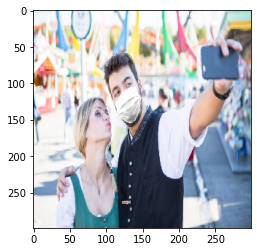

In [ ]:
# check image quality 

i = 3  # change this value to test

iterator = iter(valid_gen) # change dataset to test

augmented_img, target = next(iterator)

augmented_img = augmented_img * 255 
augmented_img = np.array(augmented_img[i])
   
plt.imshow(np.uint8(augmented_img))
plt.plot()

In [ ]:
# Create the datasets:

train_dataset = tf.data.Dataset.from_generator(lambda: train_gen, output_types=(tf.float32, tf.float32), output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, output_types=(tf.float32, tf.float32), output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
valid_dataset = valid_dataset.repeat()

test_dataset = tf.data.Dataset.from_generator(lambda: test_gen, output_types=(tf.float32, tf.float32), output_shapes=([None, img_h, img_w, 3], [None, num_classes]))


# MODELS

Here are presented different approaches.

The first two are custom networks, which are quite limited and score around 0.6.

After some tests we applied transfer learning to many different networks. Here are some that we tested

In [ ]:
# >>> WITHOUT TL - SEQUENTIAL MODEL

# feature extraction
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=16,
                                       kernel_size=(5,5),
                                       strides=(1,1),
                                       padding='same',
                                       input_shape=[img_h, img_w, 3]))
model.add(tf.keras.layers.MaxPool2D(pool_size=(5,5))) 

model.add(tf.keras.layers.Conv2D(filters=32,
                                       kernel_size=(3,3),
                                       strides=(1,1),
                                       padding='same',
                                       input_shape=[None]))

model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3))) 



model.add(tf.keras.layers.Conv2D(filters=64,
                                       kernel_size=(2,2),
                                       strides=(1,1),
                                       padding='same',
                                       input_shape=[None]))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) 

model.add(tf.keras.layers.Conv2D(filters=64,
                                       kernel_size=(2,2),
                                       strides=(1,1),
                                       padding='same',
                                       input_shape=[None]))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) 


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# <<< WITHOUT TL

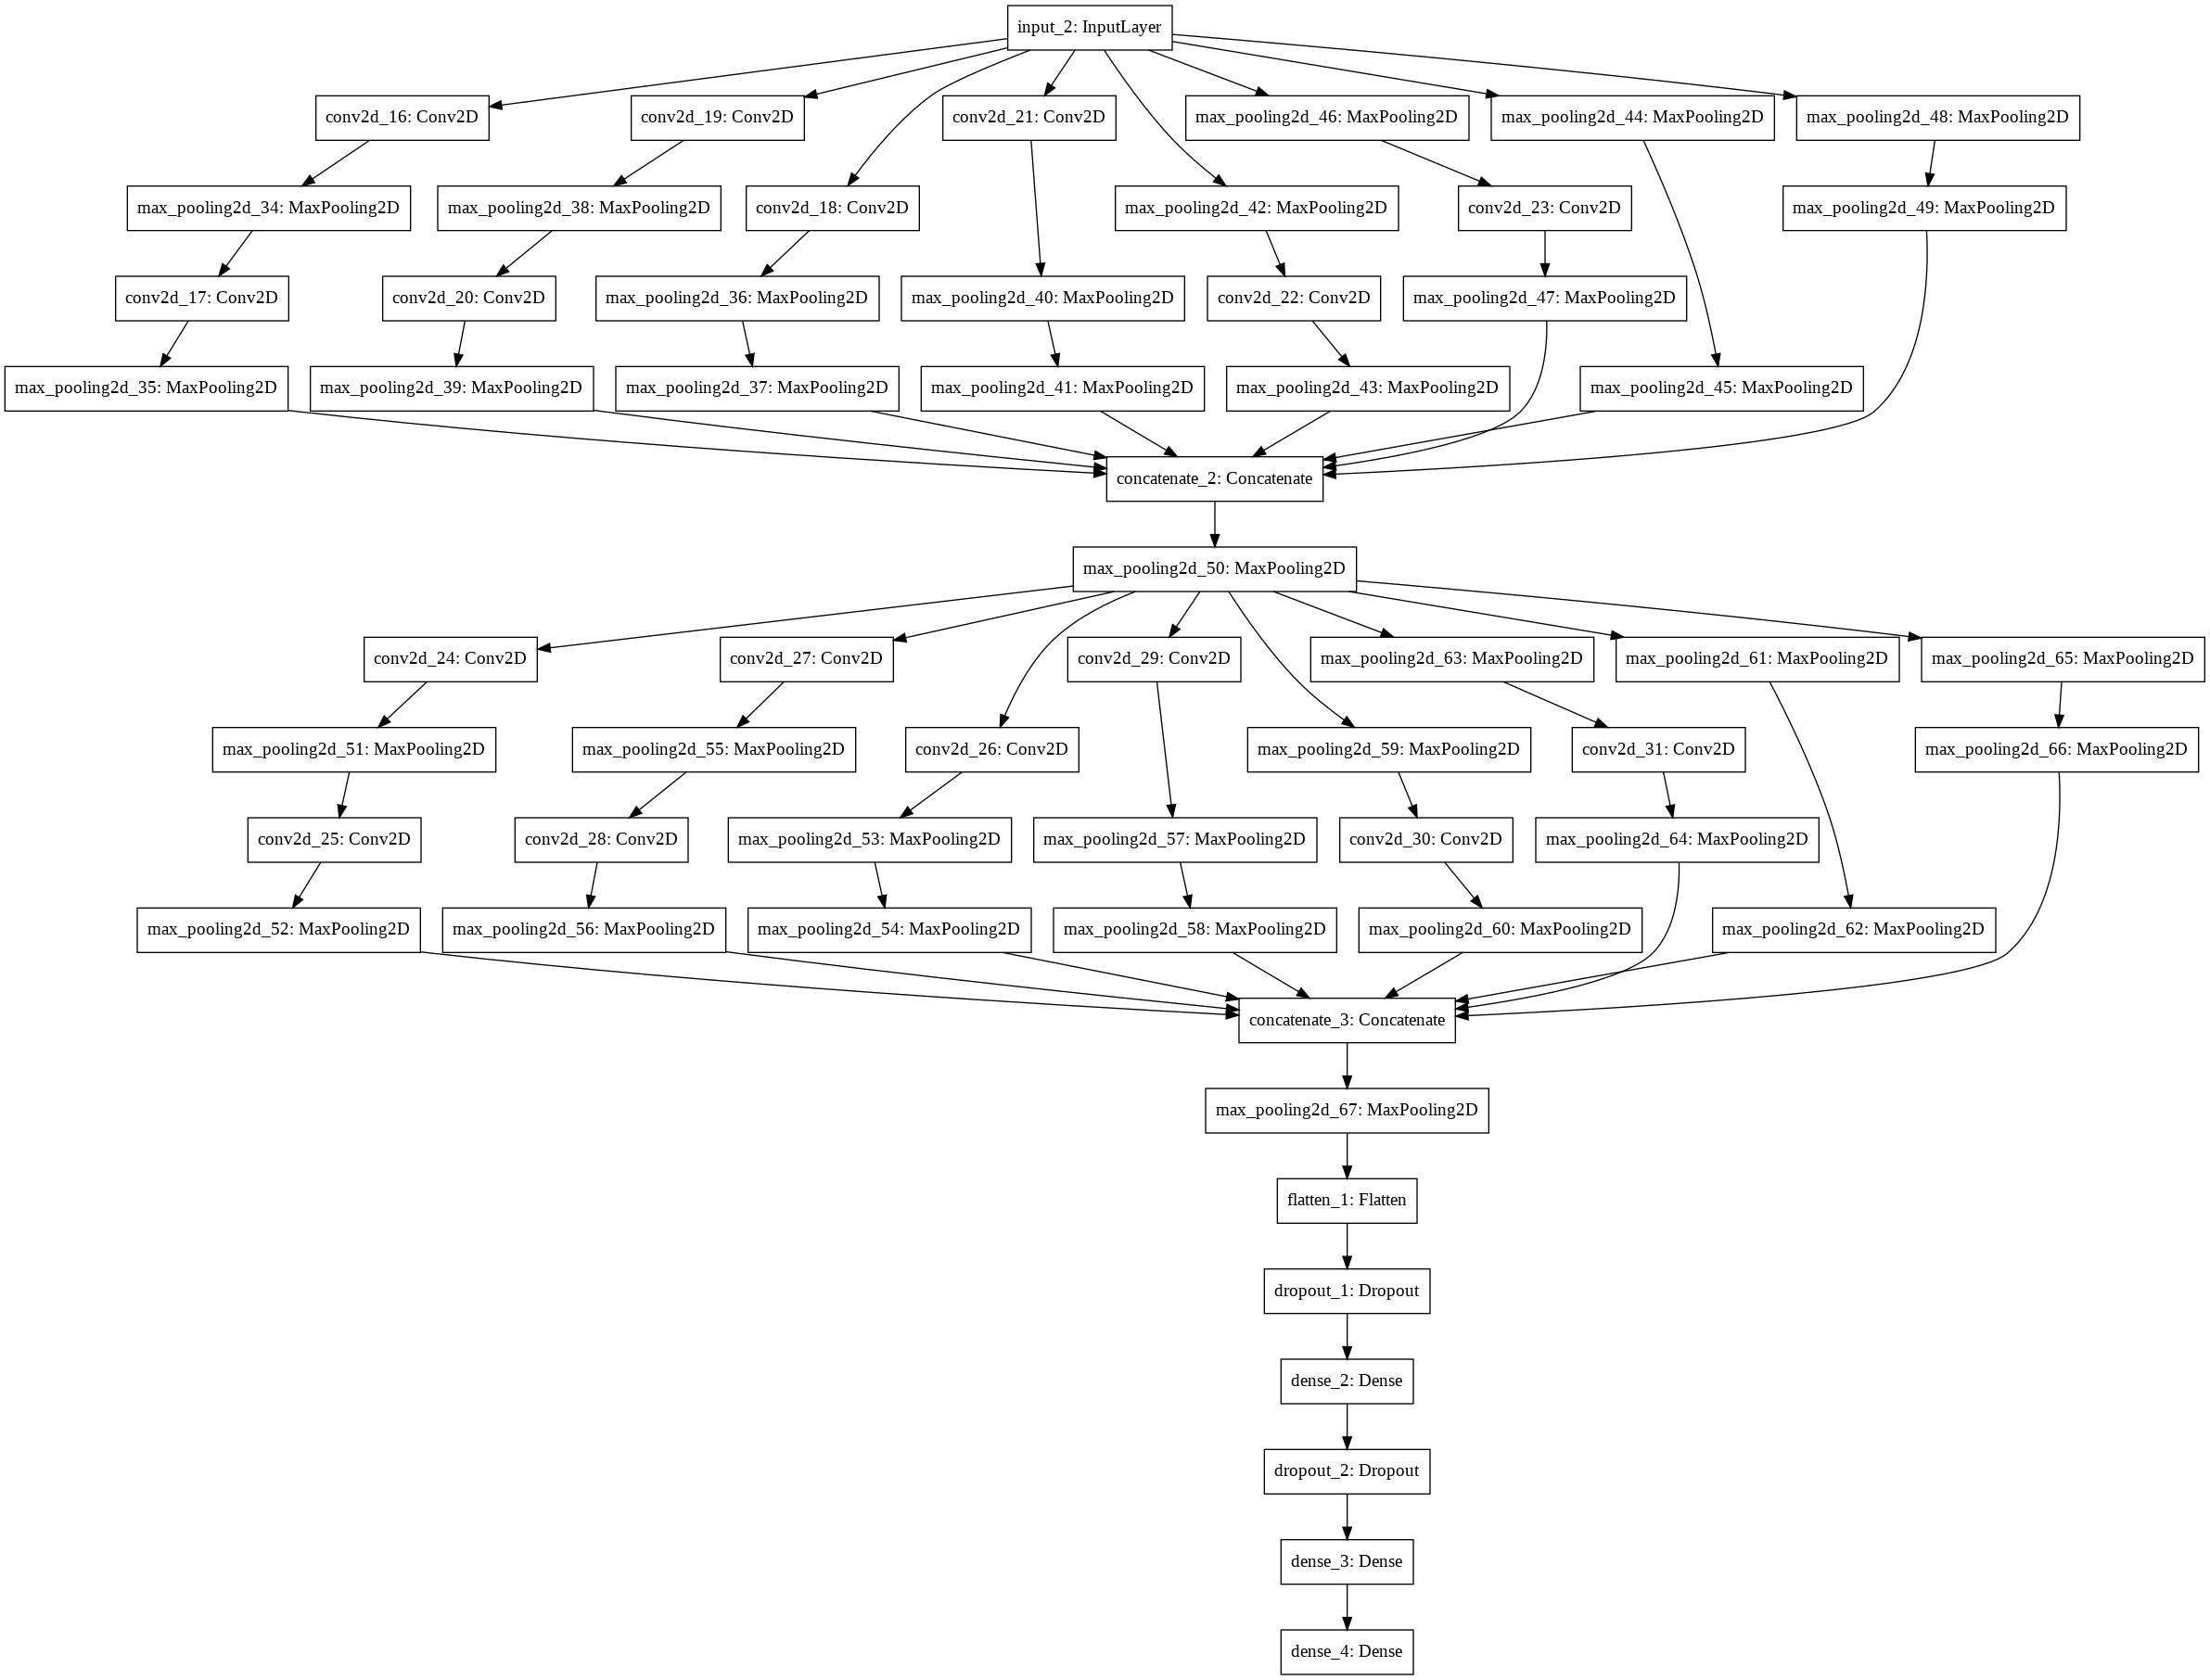

In [ ]:
# >>> WITHOUT TL - PARALLELIZED CONVOLUTIONS MODEL

num_towers = 8
depth = 2

def conv_block(input_shape, num_filters, kernel_size, add_conv): # A conv_block can contain convolution + max pool or just max pooling
  if(add_conv): 
    block = Conv2D(filters=num_filters, kernel_size=kernel_size, padding='same', activation='relu')(input_shape)
    input_shape = block
  block = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(input_shape)
  return block

def double_conv_block(input_shape, num_filters, kernel_size, add_conv_1, add_conv_2): # A combination of two conv_blocks
  block = conv_block(input_shape, num_filters, kernel_size, add_conv_1)
  new_kernel_size = (max(1, kernel_size[0]-2),  max(1, kernel_size [1]-2*num_towers))
  block = conv_block(block, num_filters*2, new_kernel_size, add_conv_2)
  return block


input = Input(shape=(img_h, img_w, 3))

# Feature extraction

for i in range(depth):
  
  if (i == 0): input_shape = input
  else: input_shape = out

  towers = [None] * num_towers

  # Customize the blocks changing the filter size (to get features with different 
  # levels of resolution), the number of filters (to get more features) and
  # remove the convolutions in some towers

  for j in range(num_towers):  
    ksx = (num_towers - j+3)
    ksy = (num_towers - j+3) * num_towers
    c1 = (j<num_towers/2)
    c2 = (j%2==0)

    towers[j] = double_conv_block(input_shape, 
                                  num_filters=((j+1)*2+10), 
                                  kernel_size=(ksx, ksy), 
                                  add_conv_1 = c1, 
                                  add_conv_2 = c2)

  out = concatenate(towers)
  #out = Conv2D(filters=(i+10), kernel_size=(2,2), padding='same', activation='relu')(out)
  out = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(out)


out = Flatten()(out)


out = Dropout(0.5)(out)
out = Dense(1024, activation='relu')(out)
# out = Dropout(0.5)(out)
# out = Dense(256, activation='relu')(out)

out = Dense(num_classes, activation='softmax')(out)


model = Model(input, out)
tf.keras.utils.plot_model(model, to_file=model_draw)


# <<< WITHOUT TL

In [ ]:
# >>> WITHOUT TL - SEQUENTIAL MODEL

##### WARNING: this model have been trained with different hyperparameters: to reproduce it, change the following values in the previous cells:
##### bs = 20
##### img_h = 256
##### img_w = 256
##### validation_split (in ImageDataGenerator) = 0.15


start_f = 15
depth = 5

model = tf.keras.Sequential()
for i in range(depth): #repete the block for depth times
  if i == 0:
    input_shape = [img_h, img_w, 3]
  else:
      input_shape=[None]
  
  model.add(tf.keras.layers.Conv2D(filters=start_f,
                                       kernel_size=(3,3),
                                       strides=(1,1),
                                       padding='same',
                                       input_shape=input_shape))  
  model.add(tf.keras.layers.ReLU())
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
  start_f *=2

model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# <<< WITHOUT TL

In [ ]:
# >>> XCEPTION
# We tried to tune the hyperparameters and we found the best result freezing the first 15 layers of the net. 
# We also tried to remove the top, but we achieved the best results including it

net = tf.keras.applications.Xception()
freeze_until = 0 #15 # len(net.layers) - 5

for layer in net.layers[:freeze_until]:
        layer.trainable = False

model = tf.keras.Sequential()
model.add(net)

model.add(Flatten())
model.add(Dropout(0.5)) 
model.add(Dense(units=2048, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))

model.add(Dense(num_classes, 'softmax'))

# <<< XCEPTION

In [ ]:
# >>> VGG FACES

# We tried with VGGFaces because we thought that it would berform best because
# it was specialized in a field similar to ours, but it turned out to be not so 
# efficient

model = tf.keras.Sequential()

vgg_model = VGGFace(include_top=False, input_shape=(img_h, img_w, 3))


freeze_until = len(vgg_model.layers) - 7

for layer in vgg_model.layers[:freeze_until]:
        layer.trainable = False

model.add(vgg_model)
model.add(Flatten())

model.add(Dropout(0.5)) 
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units=64, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))

# <<< VGG FACES

58916864/58909280 [==============================] - 1s 0us/step


In [ ]:
# >>> DENSE NET

# After some tests, we found out that this was one of the most performing model.
# We noticed some overfitting appending to the net only the dense layers, so we decided to add also dropout.
# We trained the network from scratch, and we found this very efficient

net = tf.keras.applications.DenseNet169(include_top= True, weights='imagenet',input_tensor=None,input_shape=None, pooling= None, classes=1000)

model = tf.keras.Sequential()
model.add(net)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation='softmax'))

# <<< DENSE NET

Here is our best model:

In [ ]:
# >>> XCEPTION

# We kept trying to finetune the Xception net because it looked very promising. After some trials we found out that 
# including the top and freezing the first 20 layers gave us the best result. Dropout has been added only after 
# our Dense layer while we tried to remove it from the exit of the Xception network.

#### WARNING: this model has been trained with different hyperparameters. To reproduce it change the following values in previous cells:
#### SEED = 6669
#### bs = 10

net = tf.keras.applications.Xception(include_top = True, weights='imagenet',input_tensor=None,input_shape=(299, 299, 3), pooling= None)

finetuning = True
numberOfLayers = 20
if finetuning:
    freeze_until = numberOfLayers  # layer from which we want to fine-tune prima era 15 con la VGG16
    
    for layer in net.layers[:freeze_until]:
        layer.trainable = False
else:
    net.trainable = False


model = tf.keras.Sequential()
model.add(net)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# <<< XCEPTION

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 1000)              22910480  
_________________________________________________________________
flatten_8 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 2048)              2050048   
_________________________________________________________________
dropout_23 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_24 (Dropout)         (None, 1024)             

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()

lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

metrics = ['accuracy']

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tb_dir --port 6006

In [ ]:
callbacks = []

# Model checkpoint

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)
callbacks.append(tb_callback)

# Early Stopping
# To reduce overfitting, we use this regularization technique

early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)

# Learning rate reduction
# When we see that the validation loss stopped improving, so that we can start 
# learning faster and then get more precision

rp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.5,
                                                     patience=2,
                                                     min_lr=0.000001,
                                                     verbose=1)
callbacks.append(rp_callback) 

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.fit(x=train_dataset, epochs=50, steps_per_epoch=len(train_gen), validation_data=valid_dataset, validation_steps=len(valid_gen), callbacks=callbacks)

Epoch 1/50
281/281 [==============================] - 282s 1s/step - loss: 1.1081 - accuracy: 0.3793 - val_loss: 1.0398 - val_accuracy: 0.5758
Epoch 2/50
281/281 [==============================] - 283s 1s/step - loss: 1.0531 - accuracy: 0.4967 - val_loss: 0.9976 - val_accuracy: 0.6471
Epoch 3/50
281/281 [==============================] - 283s 1s/step - loss: 1.0195 - accuracy: 0.5550 - val_loss: 0.9752 - val_accuracy: 0.6604
Epoch 4/50
281/281 [==============================] - 282s 1s/step - loss: 0.9913 - accuracy: 0.6080 - val_loss: 0.9662 - val_accuracy: 0.6649
Epoch 5/50
281/281 [==============================] - 282s 1s/step - loss: 0.9761 - accuracy: 0.6565 - val_loss: 0.9606 - val_accuracy: 0.6649
Epoch 6/50
281/281 [==============================] - 282s 1s/step - loss: 0.9636 - accuracy: 0.6652 - val_loss: 0.9528 - val_accuracy: 0.6640
Epoch 7/50
281/281 [==============================] - 282s 1s/step - loss: 0.9461 - accuracy: 0.6659 - val_loss: 0.9264 - val_accuracy: 0.6649

In [ ]:
# Save the model

now = datetime.now().strftime('%b%d_%H-%M-%S')
print(str(now))
model_name = os.path.join(models_dir, str(now))
classification_name = str(prediction_dir) + '/' +str(now)

model.save(model_name)

Nov22_11-16-26
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/ANNDL/models/Nov22_11-16-26/assets


In [ ]:
model = tf.keras.models.load_model(model_name)

In [ ]:
# Get the predictions 
labels = [os.path.basename(file) for file in test_gen.filenames[:]]
labels[0] = '10001.jpg'

results = model.predict(test_gen)
classes = results.argmax(axis = -1)

print(classes)
print(labels)


[2 2 1 2 2 2 1 1 2 2 1 1 1 0 2 0 1 0 0 0 1 1 2 1 1 2 0 1 2 0 2 1 1 1 2 0 1
 1 0 1 2 2 0 1 0 0 1 0 2 1 1 0 1 2 0 1 0 2 2 2 1 1 2 1 1 1 1 0 1 1 2 0 1 2
 1 0 2 1 0 0 1 1 1 2 1 1 1 2 1 2 1 2 2 1 0 2 2 2 1 1 2 1 1 0 1 0 0 0 0 0 2
 0 1 1 2 0 1 0 0 1 2 0 0 2 1 1 1 0 0 2 1 1 1 1 1 2 0 0 2 1 0 2 2 1 1 0 0 0
 0 0 2 0 2 1 1 2 1 0 0 2 0 2 2 2 1 1 2 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 2 2 0
 2 0 1 1 2 2 0 2 0 2 0 1 1 2 2 0 0 0 0 2 2 2 1 0 2 0 2 1 2 0 2 0 1 0 2 2 1
 0 1 1 1 0 0 1 1 0 0 0 2 2 1 0 1 1 1 2 1 2 1 1 1 0 2 2 2 2 1 0 2 1 0 1 1 0
 0 0 1 1 0 1 2 1 0 1 0 0 2 2 2 2 0 0 1 2 2 0 0 2 1 2 1 0 0 0 2 1 0 1 2 0 1
 1 0 0 1 2 1 1 1 2 1 0 1 2 0 0 0 0 2 1 1 1 2 0 1 1 0 2 0 1 0 0 1 0 0 2 1 0
 1 1 1 1 0 0 2 0 2 0 1 2 2 0 0 2 2 1 2 0 0 1 0 2 0 2 2 0 1 1 0 2 1 0 1 2 1
 1 1 2 1 1 0 2 0 2 1 0 0 1 1 1 0 2 1 1 0 1 0 2 1 1 0 1 1 0 1 1 0 1 0 0 2 1
 1 1 1 1 2 0 1 0 2 1 2 1 0 1 0 0 2 2 0 0 1 0 2 0 2 0 1 1 2 2 1 2 1 1 0 1 2
 0 2 1 2 0 2]
['10001.jpg', '10040.jpg', '10074.jpg', '10084.jpg', '10100.jpg', '10120.jpg', '10125.

In [ ]:
# Write results in a file

print(classification_name)
with open(classification_name, 'w') as f:
  f.write('Id,Category\n')

  for i in range(450):   
      f.write(str(labels[i]) + ',' + str(classes[i]) + '\n')
      


/content/drive/My Drive/ANNDL/results/Nov17_15-31-34
